# F1 Tire Friction Analysis

In [29]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [30]:
# read Racing_Data.pkl file
with open('Racing_Data.pkl', 'rb') as f:
    Racing_data = pickle.load(f)


![British Grand Prix Circuit with Corners](Racing_track.png)

## 1) Find the velocities

### 1a) Create a function to calculate velocities


In [31]:
def find_velocities(racer):
    """Input parameter is the racer's data dictionary.\n
    Function returns the racer's data with velocities calculated for each lap.\n
    Velocities are calculated as the time derivative of the distance data."""
    for lap in racer:        
        distances = np.array(racer[lap]["distance"])
        times = np.array(racer[lap]["time"])

        velocities = np.zeros_like(distances)


        for i in range(len(distances) - 1):
            velocities[i] = (distances[i + 1] - distances[i]) / (times[i + 1] - times[i])
        
        velocities[-1] = velocities[-2] # Last velocity is set to the second last to avoid index error
        racer[lap]["velocity"] = velocities
        racer[lap]["distance"] = distances
        racer[lap]["time"] = times
        

    return racer


for racer in Racing_data:
    Racing_data[racer] = find_velocities(Racing_data[racer])

### 1b) Average Velocity 

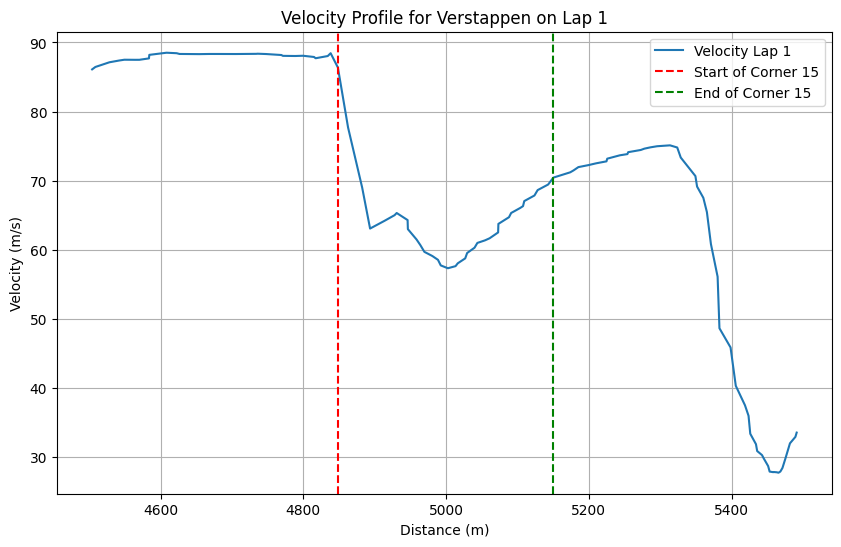

In [32]:
start_of_corner_15 = 4840
end_of_corner_15 = 5150
 
racer_name = "Verstappen"
racer_key = "VER"
lap_number = 1


distances = Racing_data[racer_key][lap_number]["distance"]
velocities = Racing_data[racer_key][lap_number]["velocity"]


left_idx = np.where(distances >= 4500)[0][0]
right_idx = np.where(distances <= 5500)[0][-1]

start_idx = np.where(distances >= start_of_corner_15)[0][0]
end_idx = np.where(distances >= end_of_corner_15)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(distances[left_idx:right_idx], 
         velocities[left_idx:right_idx], 
         label=f"Velocity Lap {lap_number}")

plt.axvline(x=distances[start_idx], 
            color='red', linestyle='--', label='Start of Corner 15')

plt.axvline(x=distances[end_idx], 
            color='green', linestyle='--', label='End of Corner 15')

plt.title(f"Velocity Profile for {racer_name} on Lap {lap_number}")
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid()
plt.show()


In [33]:
def find_start_end_indices(data, racer_key, lap_number, start_of_corner, end_of_corner):
    """Find the start and end indices for a given racer, lap and corner distance range."""
    distances = data[racer_key][lap_number]["distance"]
    
    start_index = np.where(distances >= start_of_corner)[0][0]
    end_index = np.where(distances >= end_of_corner)[0][0]
    
    return start_index, end_index


def average_velocity(data, racer_key, lap_number, start_index, end_index):
    """Calculate the average velocity for a given racer, lap and distance range."""
    velocities = data[racer_key][lap_number]["velocity"]

    return np.mean(velocities[start_index:end_index])

### 1c) Plot the average velocities through corner 15

markdown stuff

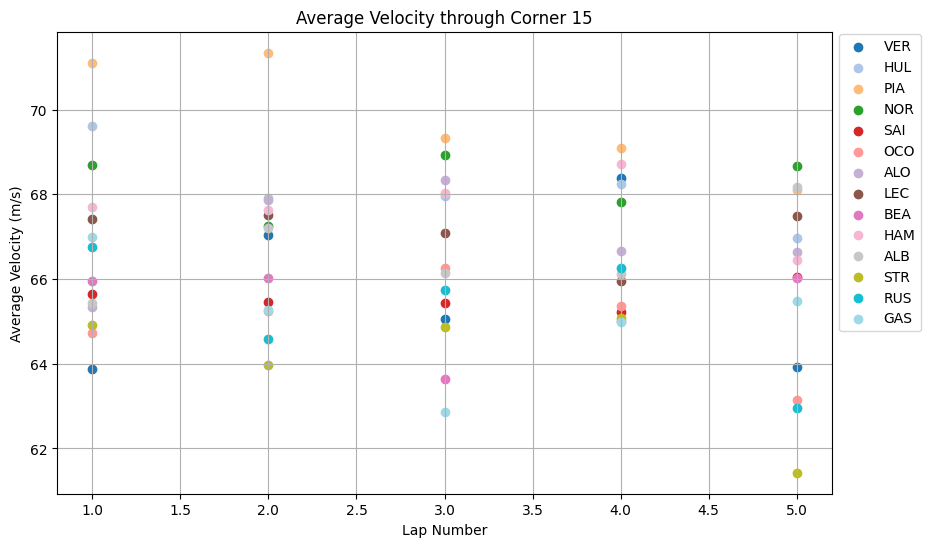

In [ ]:
colors = plt.cm.tab20(np.linspace(0, 1, len(Racing_data)))

plt.figure(figsize=(10, 6))

for i, racer in enumerate(Racing_data):
    color = colors[i]  
    for lap in Racing_data[racer]:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )

        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,         
            end_index=end_idx
        )
        plt.scatter(lap, velocity, color=color, label=racer if lap == 1 else "")

plt.xlabel("Lap Number")
plt.ylabel("Average Velocity (m/s)")
plt.title("Average Velocity through Corner 15")
plt.legend(ncol=1, bbox_to_anchor=(1, 1.01))
plt.grid()
plt.show() 
#TODO: Dont scatter, do -o plots

## 2) OLS (Ordinary Least Squares)

**What is Ordinary Least Squares?**

Ordinary Least Squares (OLS) is a method for estimating the unknown parameters in a linear regression model. It does this by minimizing the sum of the squares of the differences, which you can think of as the error, between the observed and predicted values. OLS is widely used in statistical modeling and machine learning for its simplicity and effectiveness in fitting linear relationships.

If you have some dots on a graph, in our case, the dots are the velocities on the y-axis vs lap number on the x-axis. The dots are not perfectly aligned, but we believe that they follow a trend, either increase or decrease, or maybe even a curve.

What we want to do is to draw a line that "fits" the dots as closely as possible. This line would help us describe the trend, and also make predictions about future values, like what the velocity might be on the next few laps. OLS does this by finding the best-fitting line that minimizes the distance between the line and all the dots.

**What does "best-fitting line" mean?**

Let's say you draw *any* line. Some dots will be above it, and some will be below. The difference between each dot and the line is called the **error** or **residual**. 

What OLS is saying is: "Let's choose the line that makes the sum of the squares of these errors as small as possible.". And that is why it is called least squares. The reason we square the errors is to make sure that positive and negative errors do not cancel each other out, while at the same time punishes larger errors more heavily.

**How to use OLS**
We want to fit a line of the form:
$$ \hat{y} = β_0 + β_1 x$$
where
- $ \hat{y} $ is the predicted value (velocity, in our case),
- $ x $ is the independent variable (in our case, lap number),
- $ β_0 $ is the y-intercept (the predicted value when lap number is 0),
- $ β_1 $ is the slope of the line (the change in predicted value for each additional lap).

OLS gives us the values of $ β_0 $ and $ β_1 $ that best fits the data.
The solution becomes:
$$
β = (X^T X)^{-1} X^T y
$$

where:
- $ X $ is the matrix of your inputs (lap numbers, plus a column of ones for the intercept),
- $ y $ is the column vector of observed values (velocities)


### 2a) Create a function to calculate OLS

You are now going to create a function that takes in the lap numbers and velocities, and returns the coefficients $ β_0 $ and $ β_1 $.

The first step is to create the matrix $ X $.

Build the design matrix $ X $:
```python
X = np.column_stack((np.ones(len(x)), x))  # Add a column of ones for the intercept
```
where `x` is the lap numbers.

The second step is to calculate the coefficients using the formula:
```python
beta = np.linalg.inv(X.T @ X) @ X.T @ y  # Calculate the coefficients
```

Now you have the coefficients $ β_0 $ from `beta[0]` and $ β_1 $ from `beta[1]`.

You can predict the velocity for any lap number using:
```python
predicted_velocity = beta[0] + beta[1] * lap_number
```

Fill in the function `OLS` below.
#TODO: Dont give them everything, give them a couple of hints and let them figure it out (You can use .... things)

In [ ]:
def OLS(x,y):
    """
    Perform Ordinary Least Squares regression.

    Parameters:
    x : array-like
        Independent variable (e.g., lap numbers).
    y : array-like
        Dependent variable (e.g., velocities).

    Returns:
    tuple : (beta_0, beta_1)
        Coefficients of the regression line.
    """

    X = np.column_stack((np.ones(len(x)), x))  # Add a column of ones for the intercept
    beta = np.linalg.inv(X.T @ X) @ X.T @ y  # Calculate
    beta_0, beta_1 = beta[0], beta[1]  # Extract coefficients
    return beta_0, beta_1

### 2b) Fit the velocities using OLS

You are now going to use the function you created in 2a to fit the velocities through corner 15 using OLS.

For simplicity, you should first average the velocities for each lap, and then fit the average velocities using OLS.

In [36]:
racer_keys = list(Racing_data.keys()) #List of racer keys
number_of_laps = len(Racing_data[racer_keys[0]]) # The number of laps for each racer

average_velocities = []

for lap in range(1, number_of_laps + 1):
    lap_velocities = []
    for racer in racer_keys:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,         
            end_index=end_idx
        )
        lap_velocities.append(velocity)
    average_velocities.append(np.mean(lap_velocities))

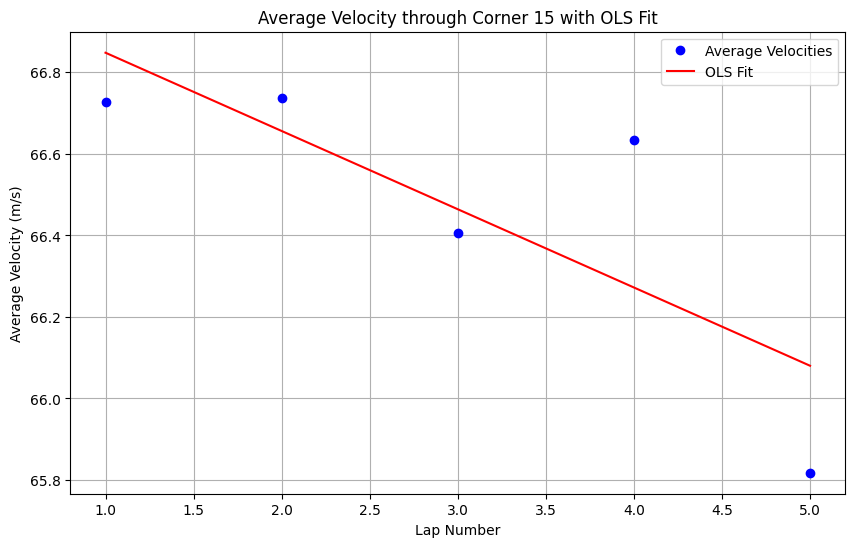

OLS Coefficients: Intercept = 67.04, Slope = -0.19


In [37]:
total_laps = np.arange(1, number_of_laps + 1)  # Array of lap numbers

beta0, beta1 = OLS(total_laps, average_velocities)

plt.figure(figsize=(10, 6))
plt.plot(total_laps, average_velocities, 'o', label='Average Velocities', color='blue')
plt.plot(total_laps, beta0 + beta1 * total_laps, '-', label='OLS Fit', color='red')
plt.xlabel("Lap Number")
plt.ylabel("Average Velocity (m/s)")
plt.title("Average Velocity through Corner 15 with OLS Fit")
plt.legend()
plt.grid()
plt.show()
print(f"OLS Coefficients: Intercept = {beta0:.2f}, Slope = {beta1:.2f}")

## 3) Calculating the friction coefficient

Now we have all the tools we would like to calculate the friction coefficient.

In order to get started with the friction coefficient, we need to make a few assumptions:


1. Corner 15 is a perfect half circle. This means that the radius of the corner is constant, and the car is always at the same distance from the center of the corner.
2. The driver is driving at the maximum speed possible through the corner, which means that the car is at the limit of the tire's grip.
3. The track is flat, which means that there is no banking in the corner.



### 3a) Free body diagram

Draw a free body diagram of the car in turn 15. We want to include the direction of motion, the centripetal force and the centrifugal force.
The centripetal force is the force that keeps the car moving in a circular path, while the centrifugal force is the apparent force that acts outward on a body moving around a center. What we mean with "apparent" is that the centrifugal force is actually not a real force, but rather a result of inertia.
You can label the forces F_c for the centripetal force and F_f for the centrifugal force.


![Free body diagram of the car in turn 15](FBD.png)


### 3b) Finding $μ$

In this section, we want to find a formula for the friction coefficient $μ$.

The first assumption we made, allows us to use the formula for centripetal acceleration $a_c = \frac{v^2}{r}$, in order to find the friction coefficient $μ$.
Since the driver is driving at maximum velocity, at which the wheels can handle without slipping, we can say that the centripetal force, $F_c = ma _c$, is equal to the friction force, $F_f = μ N$. In other words, we can use Newtons third law to say that the centripetal force must equal to the friction force.

Find an expression for the friction coefficient $μ$, dependent on the average velocity, the radius and the mass.



Solution: 
$$
μ = \frac{v^2}{g r}
$$

### 3c) Create a function to calculate the friction coefficient

Create a function that takes in the average velocity and the radius of the corner, and returns the friction coefficient $μ$.

The function should use the formula you found in 3b.
The radius of the corner can be calculated from the length of the half circle, which is the distance between the start and end of the corner, using the formula:
$$r = \frac{L}{\pi}$$
where $L$ is the length of the half circle.

In [38]:
g = 9.81 # Acceleration due to gravity in m/s^2
length_of_corner = end_of_corner_15 - start_of_corner_15 # Length of the half circle in meters
radius_of_corner = length_of_corner / np.pi # Radius of the half circle in meters (from )

def mu(v,r):
    return v**2 / (g * r)


### 3d) Approximate the friction coefficient for corner 15 

Now we can combine the OLS function you created, with the friction coefficient function you just made, to find the slope to approximate the friction coefficient for corner 15.


In [39]:
racer_keys = list(Racing_data.keys()) #List of racer keys
number_of_laps = len(Racing_data[racer_keys[0]]) # The number of laps for each racer

average_friction_coeff = []

for lap in range(1, number_of_laps + 1):
    lap_friction_coeff = []
    for racer in racer_keys:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,         
            end_index=end_idx
        )
        coeff = mu(velocity, radius_of_corner)
        lap_friction_coeff.append(coeff)
    average_friction_coeff.append(np.mean(lap_friction_coeff))

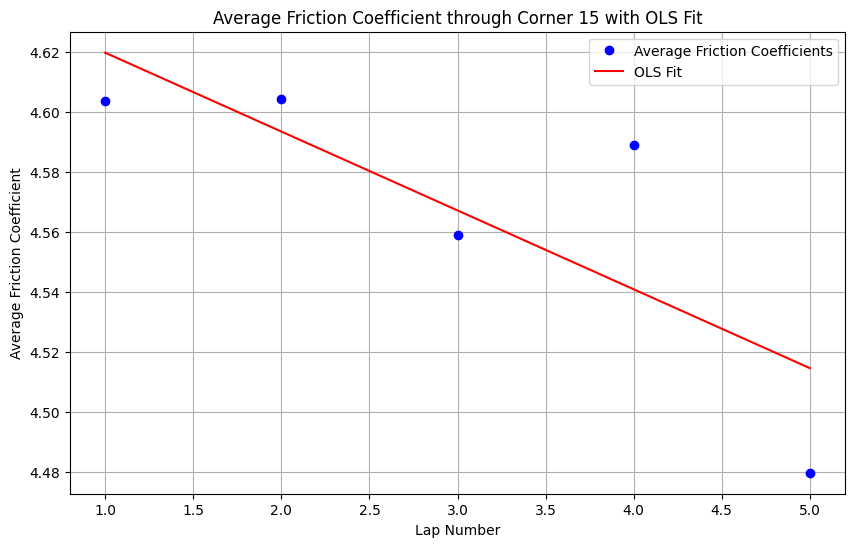

OLS Coefficients: Intercept = 4.65, Slope = -0.026


In [40]:
total_laps = np.arange(1, number_of_laps + 1)  # Array of lap numbers

beta0, beta1 = OLS(total_laps, average_friction_coeff)

plt.figure(figsize=(10, 6))
plt.plot(total_laps, average_friction_coeff, 'o', label='Average Friction Coefficients', color='blue')
plt.plot(total_laps, beta0 + beta1 * total_laps, '-', label='OLS Fit', color='red')
plt.xlabel("Lap Number")
plt.ylabel("Average Friction Coefficient")
plt.title("Average Friction Coefficient through Corner 15 with OLS Fit")
plt.legend()
plt.grid()
plt.show()
print(f"OLS Coefficients: Intercept = {beta0:.2f}, Slope = {beta1:.3f}")

If you have previously worked with friction coefficients, you might notice that friction coefficients usually are not that high. You might wonder what could have caused the high friction coefficient in this case. Do not worry, our next step is to include a factor that plays a huge role in formula 1 racing.

## 4) Improving the model

There is one thing about racing cars that we cannot ignore, and that is the downforce. Maybe the most remembered feature of the F1 cars is the huge rear wing, which is used to create downforce. The downforce is a force that pushes the car down onto the track, increasing the grip of the tires and allowing the car to go faster through corners.

So we will now have to include the downforce in our model, in order to get a more realistic friction coefficient.

### 4a) Downforce


Earlier we said that the friction force is equal to the centripetal force. But now that we introduce the downforce, we can say that the centripetal force is equal to the sum of the friction force and the downforce force:
$$
F_c = F_f + F_d
$$

where $F_d = μ C_D v²$

With the equations above, find a new expression for the friction coefficient $μ$.




Solution:
$$mv²/r = μ(mg + C_D v²)$$

$$μ = mv²/(r(mg + C_D v²))$$

### 4b) Create a function to calculate the new friction coefficient

Now it is time to create an improved function for the friction coefficient that takes into account the downforce.

Let us redefine the `mu` function to include the downforce term. The new function should include the downforce coefficient $C_D$, the mass of the car $m$, the radius of the corner $r$ and of course the average velocity $v$.

The mass of the car, including the racer, is approximately 800 kg, and the downforce coefficient $C_D$ is approximately 3.

#TODO: Make them google C_D???

In [41]:
def mu(v, r, C_D=3, m=800):
    return m * v**2 / (r * (m * g + C_D * v**2))

### 4c) Approximate the new friction coefficient 

Now we can combine the OLS function you created, with the new friction coefficient function you just made, to find the new slope to approximate the friction coefficient for corner 15 with the downforce included.

In [42]:
racer_keys = list(Racing_data.keys()) #List of racer keys
number_of_laps = len(Racing_data[racer_keys[0]]) # The number of laps for each racer

average_friction_coeff = []

for lap in range(1, number_of_laps + 1):
    lap_friction_coeff = []
    for racer in racer_keys:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,         
            end_index=end_idx
        )
        coeff = mu(velocity, radius_of_corner)
        lap_friction_coeff.append(coeff)
    average_friction_coeff.append(np.mean(lap_friction_coeff))

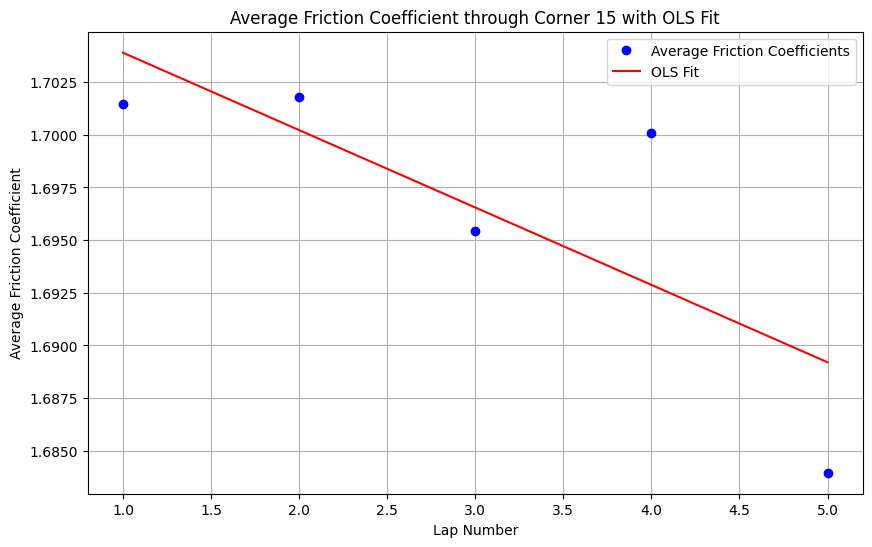

OLS Coefficients: Intercept = 1.71, Slope = -0.004


In [43]:
total_laps = np.arange(1, number_of_laps + 1)  # Array of lap numbers

beta0, beta1 = OLS(total_laps, average_friction_coeff)

plt.figure(figsize=(10, 6))
plt.plot(total_laps, average_friction_coeff, 'o', label='Average Friction Coefficients', color='blue')
plt.plot(total_laps, beta0 + beta1 * total_laps, '-', label='OLS Fit', color='red')
plt.xlabel("Lap Number")
plt.ylabel("Average Friction Coefficient")
plt.title("Average Friction Coefficient through Corner 15 with OLS Fit")
plt.legend()
plt.grid()
plt.show()
print(f"OLS Coefficients: Intercept = {beta0:.2f}, Slope = {beta1:.3f}")

Usually, the tire friction coefficient of F1 cars is around 1.7, dependent on what tires they use. Pay notice to the slope of the line you just created. How does the friction coefficient change per lap? Does it make sense?

## 5) Individual friction coefficients

In this section, we want to attempt to calculate the individual friction coefficients for racer across the laps.

### 5a) Calculate the individual friction coefficients

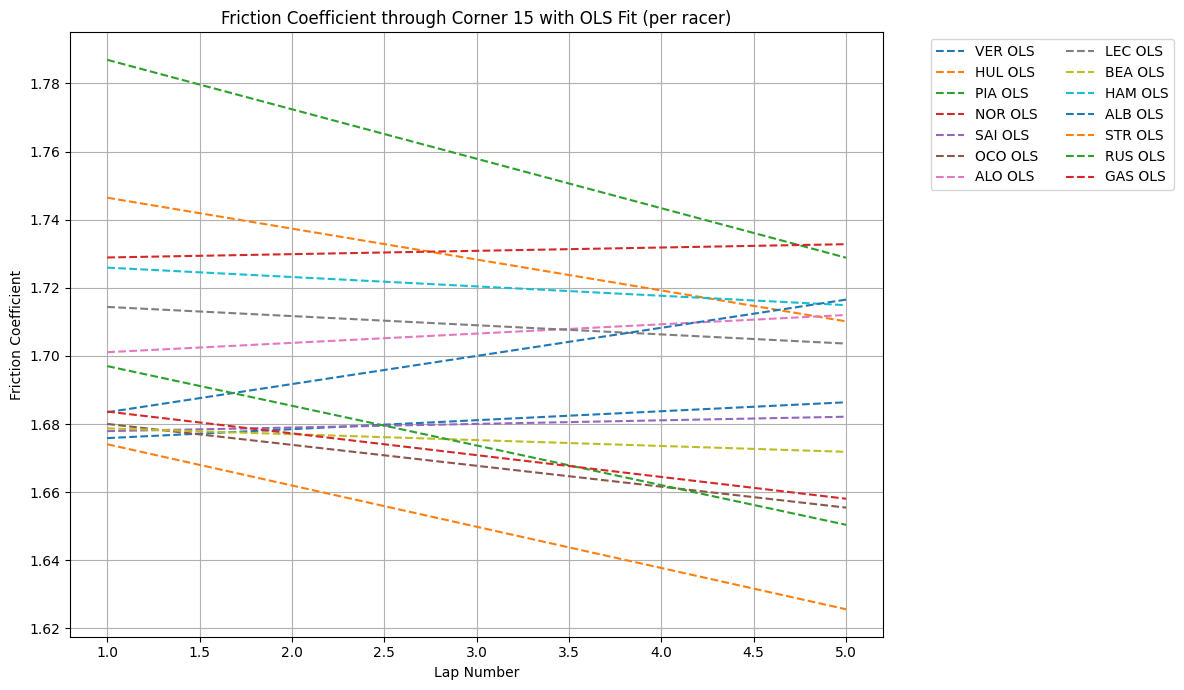

VER: Intercept = 1.673, Slope = 0.0026
HUL: Intercept = 1.756, Slope = -0.0091
PIA: Intercept = 1.801, Slope = -0.0145
NOR: Intercept = 1.728, Slope = 0.0010
SAI: Intercept = 1.677, Slope = 0.0011
OCO: Intercept = 1.686, Slope = -0.0061
ALO: Intercept = 1.698, Slope = 0.0027
LEC: Intercept = 1.717, Slope = -0.0027
BEA: Intercept = 1.680, Slope = -0.0017
HAM: Intercept = 1.729, Slope = -0.0028
ALB: Intercept = 1.675, Slope = 0.0083
STR: Intercept = 1.686, Slope = -0.0121
RUS: Intercept = 1.709, Slope = -0.0116
GAS: Intercept = 1.690, Slope = -0.0064


In [52]:
racer_keys = list(Racing_data.keys())
number_of_laps = len(Racing_data[racer_keys[0]])
total_laps = np.arange(1, number_of_laps + 1)

plt.figure(figsize=(12, 7))

ols_results = {}

for racer in racer_keys:
    racer_coeffs = []
    for lap in range(1, number_of_laps + 1):
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,
            end_index=end_idx
        )
        coeff = mu(velocity, radius_of_corner)
        racer_coeffs.append(coeff)
    racer_coeffs = np.array(racer_coeffs)
    # OLS fit for this racer
    beta0, beta1 = OLS(total_laps, racer_coeffs)
    ols_results[racer] = (beta0, beta1)
    # plt.plot(total_laps, racer_coeffs, 'o-', label=f"{racer} data")
    plt.plot(total_laps, beta0 + beta1 * total_laps, '--', label=f"{racer} OLS")

plt.xlabel("Lap Number")
plt.ylabel("Friction Coefficient")
plt.title("Friction Coefficient through Corner 15 with OLS Fit (per racer)")
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Print OLS coefficients for each racer
for racer, (beta0, beta1) in ols_results.items():
    print(f"{racer}: Intercept = {beta0:.3f}, Slope = {beta1:.4f}")

### Guess who won

## where did they change tires?
ANT = [2,9,20]
STR = [6,10,41]
HUL = [9,42]
RUS = [10,38]
LEC = [10,42]
HAD = [10]
BEA = [10,41]
PIA = [11,43]
NOR = [11,44]
VER = [11,41]
HAM = [11,41]
GAS = [11,41]
ALO = [11,37]
SAI = [11,41]
TSU = [11]
ALB = [12,42]
OCO = [18,42]